# Recurrent Neural Networks

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Time series forecasting

In [2]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [3]:
from pandas.tseries.offsets import MonthEnd

In [4]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


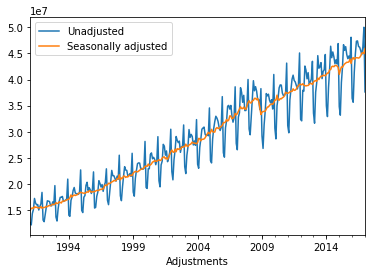

In [5]:
df.plot()

In [6]:
split_date = pd.Timestamp('01-01-2011')

In [7]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

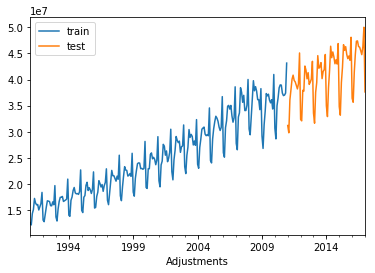

In [8]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [9]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [10]:
train_sc[:4]

array([[ 0.01402033],
       [ 0.        ],
       [ 0.0704258 ],
       [ 0.09531795]])

In [11]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

### Fully connected predictor

In [12]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [13]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [15]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
239/239 [==============================] - 1s 4ms/step - loss: 0.1774
Epoch 2/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0374
Epoch 3/200
239/239 [==============================] - ETA: 0s - loss: 0.024 - 0s 2ms/step - loss: 0.0239
Epoch 4/200
239/239 [==============================] - 1s 2ms/step - loss: 0.0213A: 0s - loss: 
Epoch 5/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 6/200
239/239 [==============================] - 1s 2ms/step - loss: 0.0174
Epoch 7/200
239/239 [==============================] - 1s 3ms/step - loss: 0.0157
Epoch 8/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 9/200
239/239 [==============================] - ETA: 0s - loss: 0.0131- ETA: 0s - loss: 0. - 1s 3ms/step - loss: 0.0131
Epoch 10/200
239/239 [==============================] - 1s 2ms/step - loss: 0.0123
Epoch 11/200
239/239 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 12/200


In [16]:
y_pred = model.predict(X_test)

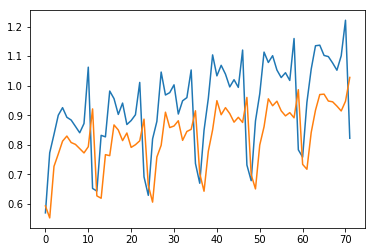

In [17]:
plt.plot(y_test)
plt.plot(y_pred)

### Recurrent predictor

In [18]:
from keras.layers import LSTM

In [19]:
X_train.shape

(239, 1)

In [20]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape

(239, 1, 1)

In [21]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [22]:
K.clear_session()
model = Sequential()
# 6 nodes with 1 step and one number input
model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 3s 13ms/step - loss: 0.1046
Epoch 2/100
239/239 [==============================] - 2s 9ms/step - loss: 0.0338
Epoch 3/100
239/239 [==============================] - 2s 7ms/step - loss: 0.0265
Epoch 4/100
239/239 [==============================] - 2s 8ms/step - loss: 0.0213
Epoch 5/100
239/239 [==============================] - 2s 9ms/step - loss: 0.0169
Epoch 6/100
239/239 [==============================] - 2s 9ms/step - loss: 0.0137
Epoch 7/100
239/239 [==============================] - 2s 9ms/step - loss: 0.0119
Epoch 8/100
239/239 [==============================] - 2s 10ms/step - loss: 0.0110
Epoch 9/100
239/239 [==============================] - 2s 10ms/step - loss: 0.0104
Epoch 10/100
239/239 [==============================] - 3s 11ms/step - loss: 0.0104
Epoch 00010: early stopping


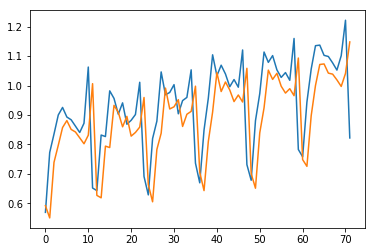

In [24]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Windows

In [31]:
train_sc.shape

(240, 1)

In [32]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [35]:
# create 12 lead values
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [36]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [37]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [38]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [39]:
X_train.shape

(228, 12)

In [46]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

### Fully Connected on Windows

In [40]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/200
228/228 [==============================] - 0s 2ms/step - loss: 0.0769
Epoch 2/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0150
Epoch 3/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 4/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0082
Epoch 5/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 6/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 7/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 8/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 9/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 10/200
228/228 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 11/200
228/228 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 12/200
228/228 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 13/200


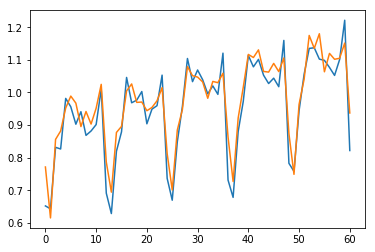

In [48]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

### LSTM on Windows

In [49]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [50]:
X_train_t.shape

(228, 1, 12)

In [51]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 3s 11ms/step - loss: 0.0408
Epoch 2/100
228/228 [==============================] - 2s 7ms/step - loss: 0.0093
Epoch 3/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0078
Epoch 4/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0071
Epoch 5/100
228/228 [==============================] - 2s 7ms/step - loss: 0.0068
Epoch 6/100
228/228 [==============================] - 2s 9ms/step - loss: 0.0057
Epoch 7/100
228/228 [==============================] - 2s 7ms/step - loss: 0.0056
Epoch 8/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 9/100
228/228 [==============================] - 2s 8ms/step - loss: 0.0042
Epoch 10/100
228/228 [==============================] - 2s 8ms/step - loss: 0.0039
Epoch 11/100
228/228 [==============================] - 2s 7ms/step - loss: 0.0033
Epoch 12/100
228/228 [==============================] - 2s 8ms/step - loss: 0.0029
Epoch 13/100

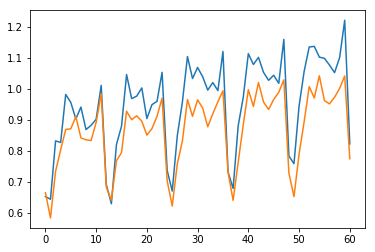

In [54]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Exercise 1

In the model above we reshaped the input shape to: `(num_samples, 1, 12)`, i.e. we treated a window of 12 months as a vector of 12 coordinates that we simultaneously passed to all the LSTM nodes. An alternative way to look at the problem is to reshape the input to `(num_samples, 12, 1)`. This means we consider each input window as a sequence of 12 values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- retrain the same LSTM(6) model, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?

## Exercise 2

RNN models can be applied to images too. In general we can apply them to any data where there's a connnection between nearby units. Let's see how we can easily build a model that works with images.

- Load the MNIST data, by now you should be able to do it blindfolded :)
- reshape it so that an image looks like a long sequence of pixels
- create a recurrent model and train it on the training data
- how does it perform compared to a fully connected? How does it compare to Convolutional Neural Networks?

(feel free to run this exercise on a cloud GPU if it's too slow on your laptop)